# Basic Development

SIR was pretty easy and simple, right? Now we step up the game. 

One of what makes COVID a big deal is the long incubation period. That means, someone infected will not become infectious right away. There will be some waiting period before the infected starts showing symptomps and can infect other people. We will name this "exposed". For this, the "infected" will be renamed to "infectious".

Next, we have yet to include deaths. COVID patients may die, and it must be modelled. This will add "dead" compartment.

Lastly, not all infected will die. Not all of them will need hospital room either. Some people with strong immune will be able to recover with enough rest and little healthcare. They will not need hospital room and they will not die. We will split the "infectious" to "infectious" and "critical", with only "critical" patients can die.

First, init.

In [60]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import mpld3
mpld3.enable_notebook()

In [61]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(13, 8))  
plt.rc('lines', linewidth=2)  

## Incubation Period, Exposed Compartment

Now we model the exposed. The previously infection rate will now be exposed rate. The infectious rate will be 1/incubation period. The flow now will be S->E->I->R. We will have 3 transitions.

- S->E = exposed_rate * susceptible * infected/population (previously S->I. yes, it uses I, not E)
- E->I = infectious_rate * exposed * 1
- I->R = recovery_rate * infectious * 1 (same as before)

In [62]:
def dseir(y, t, population, exposed_rate, infectious_rate, recovery_rate):
    susceptible, exposed, infectious, recovered = y
    exposed_flow = exposed_rate * susceptible * infectious / population
    infectious_flow = infectious_rate * exposed * 1
    recovery_flow = recovery_rate * infectious * 1
    dSdt = -exposed_flow
    dEdt = exposed_flow - infectious_flow
    dIdt = infectious_flow - recovery_flow
    dRdt = recovery_flow
    return dSdt, dEdt, dIdt, dRdt

Modify the plot function

In [63]:
def plot_seir(t, susceptible, exposed, infectious, recovered):
    f, ax = plt.subplots(1, 1)
    ax.plot(t, susceptible, 'b', alpha=0.7, label='Susceptible')
    ax.plot(t, exposed, 'y', alpha=0.7, label='Exposed')
    ax.plot(t, infectious, 'r', alpha=0.7, label='Infectious')
    ax.plot(t, recovered, 'g', alpha=0.7, label='Recovered')

    ax.set_xlabel('Time (days)', labelpad=10)

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)

    ax.grid(b=True, which='major', c='w', lw=0.5, ls='-', alpha=0.25)

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09),
              fancybox=True, shadow=True, ncol=5)
    
    
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    
        
    plt.show();

Modify the parameters

In [64]:
population = 1000
exposed_rate = 1.0  # infected person infects 1 other person per day
incubation_period = 5.0 # it requires 5 days before someone can infect others
infectious_rate = 1.0 / incubation_period
recovery_time = 4.0 # infections lasts four days
recovery_rate = 1.0 / recovery_time

susceptible_init, exposed_init, infectious_init, recovered_init = 999, 1, 0, 0  # initial conditions: one exposed, rest susceptible

Run

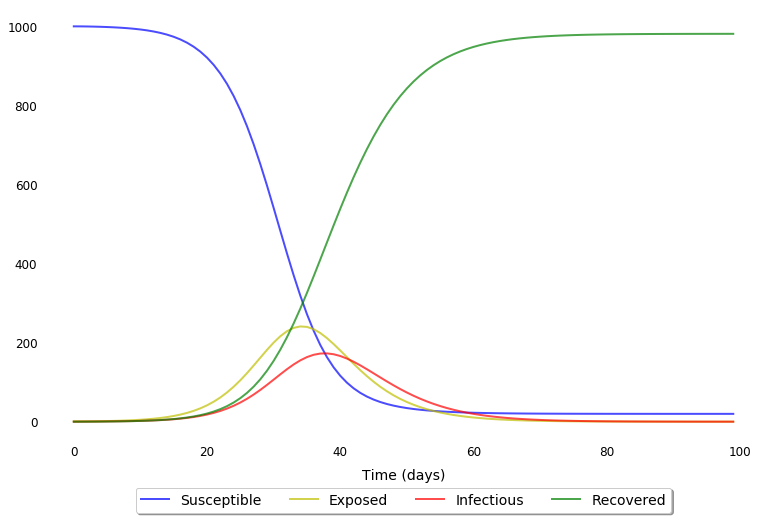

In [65]:
t = np.linspace(0, 99, 100) # 100 days, Day 0 - 99. Longer because incubation period
y0 = susceptible_init, exposed_init, infectious_init, recovered_init # Initial conditions tuple

# Integrate the SIR equations over the time grid, t.
ret = odeint(dseir, y0, t, args=(population, exposed_rate, infectious_rate, recovery_rate))
susceptible, exposed, infectious, recovered = ret.T
plot_seir(t, susceptible, exposed, infectious, recovered)

See how the infectious never go past 200 now while it used to cap at 400? 
Just one added detail affects the graph very much. 

Say the healthcare limit is 300. With previous model, there will be many people not receiving healthcare due to the limit. However, with this model, there is plenty healthcare available. See how the curve is flatter now although almost everyone got infected? This is what they meant by flattening the curve. It doesn't necessarily mean ending the outbreak wave, it's mainly just keeping it under the healthcare limit.

## Death, Split Flow

Now, let's move on to death compartment. A fraction of infectious people will die. Sounds pretty easy to model, right? Well this requires you to split the flow from infectious to two compartments, dead and recovered. We will need two additional independent variables: death rate and death risk (chance). Some infected will die, while some other recover. With death chance x, x*infected will die, while (1-x) * infected will recover. Quite complicated huh? We'll add one more dependent variable aside from the dead compartment, that is the population, just for sanity check.

- I->R = recovery_rate * infectious * (1-death_chance)
- I->D = death_rate * infectious * death_chance

In [66]:
def dpseird(y, t, population, exposed_rate, infectious_rate, recovery_rate, death_rate, death_chance):
    population, susceptible, exposed, infectious, recovered, dead = y
    exposed_flow = exposed_rate * susceptible * infectious / population
    infectious_flow = infectious_rate * exposed * 1
    recovery_flow = recovery_rate * infectious * (1-death_chance)
    death_flow = death_rate * infectious * death_chance
    dSdt = -exposed_flow
    dEdt = exposed_flow - infectious_flow
    dIdt = infectious_flow - recovery_flow - death_flow
    dRdt = recovery_flow
    dDdt = death_flow
    dPdt = dSdt + dEdt + dIdt + dRdt + dDdt
    return dPdt, dSdt, dEdt, dIdt, dRdt, dDdt

In [70]:
def plot_pseird(t, population, susceptible, exposed, infectious, recovered, dead):
    f, ax = plt.subplots(1, 1)
    ax.plot(t, susceptible, 'b', alpha=0.7, label='Susceptible')
    ax.plot(t, exposed, 'y', alpha=0.7, label='Exposed')
    ax.plot(t, infectious, 'r', alpha=0.7, label='Infectious')
    ax.plot(t, recovered, 'g', alpha=0.7, label='Recovered')
    ax.plot(t, dead, 'black', alpha=0.7, label='Dead')
    ax.plot(t, population, 'grey', alpha=0.7, label='Population')

    ax.set_xlabel('Time (days)', labelpad=10)

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)

    ax.grid(b=True, which='major', c='w', lw=0.5, ls='-', alpha=0.25)

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09),
              fancybox=True, shadow=True, ncol=6)
    
    
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    
        
    plt.show();

In [71]:
population = 1000
exposed_rate = 1.0  # infected person infects 1 other person per day
incubation_period = 5.0 # it requires 5 days before someone can infect others
infectious_rate = 1.0 / incubation_period
recovery_time = 4.0 # infections lasts four days
recovery_rate = 1.0 / recovery_time
death_time = 3.0 # dying patients die in 3 days
death_rate = 1 / death_time
death_chance = 0.2 #20% patients die

population_init, susceptible_init, exposed_init, infectious_init, recovered_init, dead_init = population, 999, 1, 0, 0, 0  # initial conditions: one exposed, rest susceptible

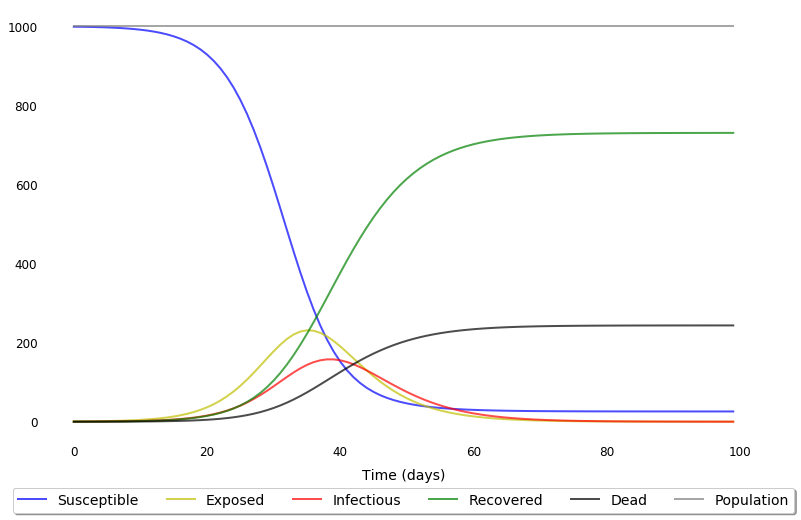

In [72]:
t = np.linspace(0, 99, 100) # 100 days, Day 0 - 99. Longer because incubation period
y0 = population_init, susceptible_init, exposed_init, infectious_init, recovered_init, dead_init # Initial conditions tuple

# Integrate the SIR equations over the time grid, t.
ret = odeint(dpseird, y0, t, args=(population, exposed_rate, infectious_rate, recovery_rate, death_rate, death_chance))
population_2, susceptible, exposed, infectious, recovered, dead = ret.T
plot_pseird(t, population_2, susceptible, exposed, infectious, recovered, dead)

## Critical Patients, Modifying Split Flow

Lastly, let's do the critical compartment. We'll be messing with split flows so let's keep the population.

Infectious people now can recover or become critical. Next, the critical will recover or die. Just like dead compartment, we need the rate of people going critical, the chance that an infected will become critical, and the rate of critical people recovering. We'll be renaming some parameters too. The critical are isolated in hospitals, so they will not be infecting people.

- I->R : recovery_rate_normal * infectious * (1-critical_chance)
- I->C : critical_rate * infectious * critical_chance
- C->R : recovery_rate_critical * critical * (1-death_chance)
- C->D : death_rate * critical * death_chance

In [75]:
def dpseicrd(y, t, population, exposed_rate, infectious_rate, critical_rate, critical_chance, recovery_rate_normal, recovery_rate_critical, death_rate, death_chance):
    population, susceptible, exposed, infectious, critical, recovered, dead = y
    exposed_flow = exposed_rate * susceptible * infectious / population
    infectious_flow = infectious_rate * exposed * 1
    critical_flow = critical_rate * infectious * critical_chance
    recovery_flow_normal = recovery_rate_normal * infectious * (1-critical_chance)
    recovery_flow_critical = recovery_rate_critical * critical * (1-death_chance)
    death_flow = death_rate * critical * death_chance
    dSdt = -exposed_flow
    dEdt = exposed_flow - infectious_flow
    dIdt = infectious_flow - recovery_flow_normal - critical_flow
    dCdt = critical_flow - recovery_flow_critical - death_flow
    dRdt = recovery_flow_normal + recovery_flow_critical
    dDdt = death_flow
    dPdt = dSdt + dEdt + dIdt + dCdt + dRdt + dDdt
    return dPdt, dSdt, dEdt, dIdt, dCdt, dRdt, dDdt

In [78]:
def plot_pseicrd(t, population, susceptible, exposed, infectious, critical, recovered, dead):
    f, ax = plt.subplots(1, 1)
    ax.plot(t, susceptible, 'b', alpha=0.7, label='Susceptible')
    ax.plot(t, exposed, 'y', alpha=0.7, label='Exposed')
    ax.plot(t, infectious, 'r', alpha=0.7, label='Infectious')
    ax.plot(t, critical, 'orange', alpha=0.7, label='Critical')
    ax.plot(t, recovered, 'g', alpha=0.7, label='Recovered')
    ax.plot(t, dead, 'black', alpha=0.7, label='Dead')
    ax.plot(t, population, 'grey', alpha=0.7, label='Population')

    ax.set_xlabel('Time (days)', labelpad=10)

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)

    ax.grid(b=True, which='major', c='w', lw=0.5, ls='-', alpha=0.25)

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09),
              fancybox=True, shadow=True, ncol=7)
    
    
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    
        
    plt.show();

In [79]:
population = 1000
exposed_rate = 1.0  # infected person infects 1 other person per day
incubation_period = 5.0 # it requires 5 days before someone can infect others
infectious_rate = 1.0 / incubation_period
recovery_time_normal = 4.0 # infections lasts four days for normal infection
recovery_rate_normal = 1.0 / recovery_time_normal
death_time = 3.0 # dying patients die in 3 days
death_rate = 1.0 / death_time
death_chance = 0.2 #20% patients die
critical_time = 7.0 #people may become critical after a week
critical_rate = 1.0 / critical_time
critical_chance = 0.4 #40% infected will need hospital care
recovery_time_critical = 5.0 # infections lasts 5 days for critical patients
recovery_rate_critical = 1.0 / recovery_time_critical

population_init, susceptible_init, exposed_init, infectious_init, critical_init, recovered_init, dead_init = population, 999, 1, 0, 0, 0, 0  # initial conditions: one exposed, rest susceptible

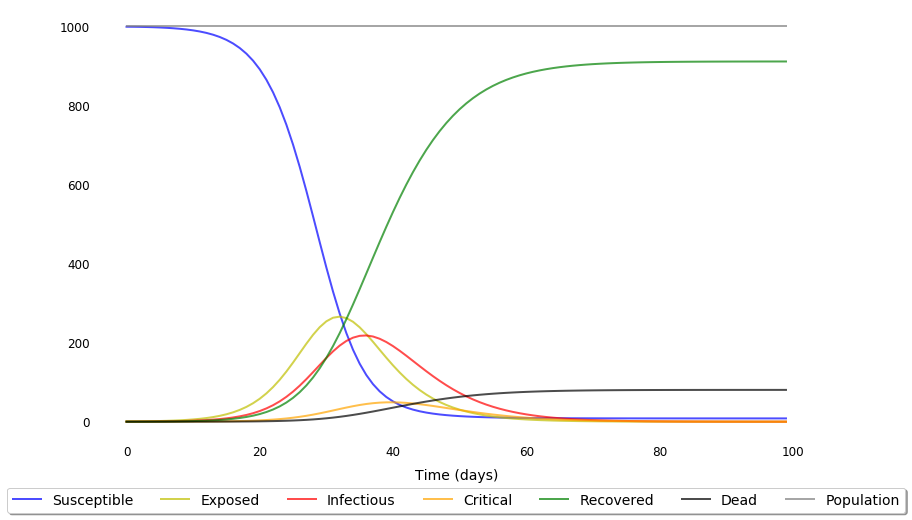

In [82]:
t = np.linspace(0, 99, 100) # 100 days, Day 0 - 99. Longer because incubation period
y0 = population_init, susceptible_init, exposed_init, infectious_init, critical_init, recovered_init, dead_init # Initial conditions tuple

# Integrate the SIR equations over the time grid, t.
ret = odeint(dpseicrd, y0, t, args=(population, exposed_rate, infectious_rate, critical_rate, critical_chance, recovery_rate_normal, recovery_rate_critical, death_rate, death_chance))
population_2, susceptible, exposed, infectious, critical, recovered, dead = ret.T
plot_pseicrd(t, population_2, susceptible, exposed, infectious, critical, recovered, dead)

Turns out not that many people needs healthcare, eh? Well they're all random numbers. Meaningless, for now.

This concludes the basic development notebook.